# Lesson S3 - Regridding the AORC forcing data to the WRF-Hydro domain

## Overview
In this lesson, we cover regridding the AORC forcing data to a WRF-Hydro domain using the Python-based WRF-Hydro Forcing Engine

## Required software and datasets

### Meteorological Forcing Engine (MFE) software
The WRF-Hydro Meteorological Forcing Engine (MFE) software can be downloaded from https://github.com/NCAR/WrfHydroForcing

### Data sources
The AORC dataset is created by the AORC team at NOAA. The dataset covers southern Canada, the conterminous United States (CONUS), and northern Mexico, including all contributing areas for the CONUS surface waters. The dataset is available from February 1979 to the present. AORC is developed using a blend of climatology, historical measurements and model data. 

The dataset can be used in its gridded form to force distributed hydrologic, snow-process, or land-surface models. AORC's fields can also be spatially- and temporally-averaged to drive lumped-basin models.

The NWM V2.1 was calibrated using the AORC dataset.

**Step 1:** View the contents of the input_files directory

In [1]:
%%bash
ls ~/example_case/Forcing_Engine/input | head -10

AORC-OWP_2021013100z_example.nc
AORC-OWP_2021013101z_example.nc
AORC-OWP_2021013102z_example.nc
AORC-OWP_2021013103z_example.nc
AORC-OWP_2021013104z_example.nc
AORC-OWP_2021013105z_example.nc
AORC-OWP_2021013106z_example.nc
AORC-OWP_2021013107z_example.nc
AORC-OWP_2021013108z_example.nc
AORC-OWP_2021013109z_example.nc


Let's view the data in the AORC inputs:

In [3]:
import xarray as xr
import hvplot.xarray

aorc_in = xr.open_mfdataset('/home/docker/example_case/Forcing_Engine/input/AORC-OWP_20210131??z_example.nc')

input_field = aorc_in.APCP_surface

print(input_field)

#input_field.plot()

input_field.hvplot(groupby='time', data_aspect=1.0, xaxis=None, yaxis=None) #,
                   #title=input_field.short_name, attr_labels=False, widget_location='bottom',
                   #cmap='gist_ncar', clim=(input_field.min(), input_field.max()))

<xarray.DataArray 'APCP_surface' (time: 12, latitude: 1200, longitude: 1200)>
dask.array<concatenate, shape=(12, 1200, 1200), dtype=float32, chunksize=(1, 1200, 1200), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 38.01 38.02 38.02 38.03 ... 47.98 47.99 48.0
  * longitude  (longitude) float64 -79.99 -79.99 -79.98 ... -70.02 -70.01 -70.0
  * time       (time) datetime64[ns] 2021-01-31 ... 2021-01-31T12:00:00
Attributes:
    long_name:   Total Precipitation
    short_name:  APCP_surface
    units:       kg/m^2
    level:       surface


:DynamicMap   [time]
   :Image   [longitude,latitude]   (APCP_surface)

**Step 3: View the domain metadata files**

The Forcing Engine requires two additional static input files; a WRF *geogrid* file (for grid information), and an optional Spatial Metadata template file to copy attributes from.

In [ ]:
%%bash
ls /home/docker/example_case/Calibration/Input_Files/01447720/*.nc

We have the necessary files, now we can begin the regridding process.

## Editing the forcing engine configuration file
The WRF-Hydro Forcing Engine requires a configuration file to specify the input types, forecast time periods, and other options needed for regridding and pre-processing the forcing data.

**Step 1: Examine the supplied *aorc*.config* configuration file and verify the times and forcing input types**

In [4]:
%%bash
cat /home/docker/example_case/Forcing_Engine/Config/aorc_forcing_engine_202101.config

#--------------------------------------------------------------------
# WRF-Hydro Forcing Engine Configuration File
#
# Input options to the forcing engine include:
# 1.) Choices for input forcing files to use.
# 2.) Options for specifying date ranges and forecast intervals
#     for input files.
# 3.) Choices for ESMF regridding techniques.
# 4.) Choices for optional downscaling techniques.
# 5.) Choices for optional bias correction techniques.
# 6.) Choices for optional supplemental precipitation products.
# 7.) Choices for optional ensemble member variations.
# 8.) Choices for output directories to place final output files.

[Input]
# Choose a set of value(s) of forcing variables to be processed for
# WRF-Hydro. Please be advised that the order of which the values are
# chosen below are the order that the final products will be layered
# into the final LDASIN files. See documentation for additional
# information and examples.
# The following is a global set of key values to map forc

## Regridding the forcing data using the forcing engine
In this section we will regrid all our forcing data using the configuration shown above

**Step 2: Run the Forcing Engine driver (`genForcing.py`)**

`genForcing.py` takes 3 arguments: the path to the configuration file, a version number, and a configuration name. The version and name are arbitrary and used for logging and are inserted as netCDF Global Attributes in the LDASIN output files.

In [5]:
%%bash
cd /home/docker/example_case/Forcing_Engine/Config
rm -rf ../output/* LOG*          # clean up any existing runs
python /home/docker/WrfHydroForcing/genForcing.py aorc_forcing_engine_202101.config 5.2.0 AORC

The Forcing Engine sends most of its output to a log file specified in the configuration file. Only severe errors are printed to *stdout* so a successful run will produce no output.

**Step 3: View the Forcing Engine Log:**

In [6]:
%%bash
ls /home/docker/example_case/Forcing_Engine/output/*LOG*

/home/docker/example_case/Forcing_Engine/output/LOG_AORC_202107301827_202101310000


**Step 4: View the contents of the *output_files* directory**

The Forcing Engine will generate output files in a directory heirarchy rooted in `output_files`. Lets view the contents of the directory:

In [7]:
%%bash
ls -R /home/docker/example_case/Forcing_Engine/output/2021013100

/home/docker/example_case/Forcing_Engine/output/2021013100:
202101310000.LDASIN_DOMAIN1
202101310100.LDASIN_DOMAIN1
202101310200.LDASIN_DOMAIN1
202101310300.LDASIN_DOMAIN1
202101310400.LDASIN_DOMAIN1
202101310500.LDASIN_DOMAIN1
202101310600.LDASIN_DOMAIN1
202101310700.LDASIN_DOMAIN1
202101310800.LDASIN_DOMAIN1
202101310900.LDASIN_DOMAIN1
202101311000.LDASIN_DOMAIN1
202101311100.LDASIN_DOMAIN1
WrfHydroForcing.COMPLETE


**Step 5: View the contents of the LDASIN files**

Now, let's look at the actual regridded data in the output files. Try changing the variable from "RAINRATE" to others in the file to see the other fields.

In [8]:
import xarray as xr
import hvplot.xarray

aorc_in = xr.open_mfdataset('/home/docker/example_case/Forcing_Engine/output/2021013100/20210131??00.LDASIN_DOMAIN1')

aorc_in

<xarray.Dataset>
Dimensions:         (reference_time: 1, time: 12, x: 22, y: 28)
Coordinates:
  * time            (time) datetime64[ns] 2021-01-31 ... 2021-01-31T11:00:00
  * reference_time  (reference_time) datetime64[ns] 2021-01-31
  * x               (x) float64 1.714e+06 1.715e+06 ... 1.734e+06 1.735e+06
  * y               (y) float64 3.435e+05 3.445e+05 ... 3.695e+05 3.705e+05
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    U2D             (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
    LQFRAC          (time, y, x) float64 dask.array<chunksize=(1, 28, 22), meta=np.ndarray>
Attributes:
    model_output_valid_time:    2021-01-31_00:00:00
    model_initialization_time:  2021-01-31_00:00:00
    NWM_version_number:         v5.2.0
    model_configuration:        AORC
    model_output_type:          forcing
    model_total_valid_times:    12.0

In [9]:
output_field = aorc_in.RAINRATE

#output_field.plot()
output_field.hvplot(groupby='time', data_aspect=1.0, xaxis=None, yaxis=None, 
                    title=output_field.name, attr_labels=False, widget_location='bottom',
                    cmap='gist_ncar', clim=(output_field.min(), output_field.max()))

Column
    [0] HoloViews(DynamicMap, widget_location='bottom')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] DiscreteSlider(margin=(20, 20, 20, 20), name='time', options=OrderedDict([('2021-01-31 ...]), value=numpy.datetime64('2021-01-..., width=250)
        [2] HSpacer()

© UCAR 2020

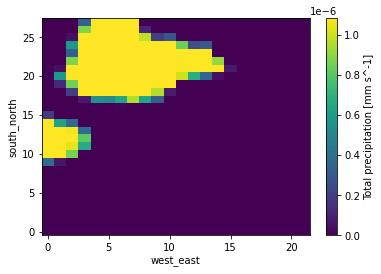

In [34]:
# FOR AREZOO TESTING
import xarray as xr
import hvplot.xarray

aorc_in = xr.open_mfdataset('/home/docker/example_case/Calibration/Input_Files/01447720/FORCING/2011031114.LDASIN_DOMAIN1')

aorc_in
output_field = aorc_in.RAINRATE
output_field.plot()